In [4]:
pip install tensorflow==2.5.0


  Using cached numpy-1.19.5-cp39-cp39-win_amd64.whl.metadata (2.0 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl.metadata (2.0 kB)
Using cached numpy-1.19.5-cp39-cp39-win_amd64.whl (13.3 MB)
Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.10.0
    Uninstalling typing_extensions-4.10.0:
      Successfully uninstalled typing_extensions-4.10.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sqlalchemy 2.0.28 requires typing-extensions>=4.6.0, but you have typing-extensions 3.7.4.3 which is incompatible.
altair 5.2.0 requires typing-extensions>=4.0.1; python_version < "3.11", but you have typing-extensions 3.7.4.3 which is incompatible.
gradio 4.21.0 requires pydantic>=2.0, but you have pydantic 1.9.2 which is incompatible.
gradio 4.21.0 requires typing-extensions~=4.0, but you have typing-extensions 3.7.4.3 which is incompatible.
gradio-client 0.12.0 requires typing-extensions~=4.0, but you have typing-extensions 3.7.4.3 which is incompatible.
ml-dtypes 0.3.2 requires numpy>1.20, but you have numpy 1.19.5 which is incompatible.
optree 0.10.0 requires typing-extensions>=4.0.0, but you have typing-extensions 3.7.4.3 which is inco

In [5]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np  
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=80

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Indian Medicinal Leaves Image Datasets/Medicinal plant dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5945 files belonging to 40 classes.


In [5]:
class_names = dataset.class_names
class_names

['Aloevera',
 'Amla',
 'Amruta_Balli',
 'Arali',
 'Ashoka',
 'Ashwagandha',
 'Avacado',
 'Bamboo',
 'Basale',
 'Betel',
 'Betel_Nut',
 'Brahmi',
 'Castor',
 'Curry_Leaf',
 'Doddapatre',
 'Ekka',
 'Ganike',
 'Gauva',
 'Geranium',
 'Henna',
 'Hibiscus',
 'Honge',
 'Insulin',
 'Jasmine',
 'Lemon',
 'Lemon_grass',
 'Mango',
 'Mint',
 'Nagadali',
 'Neem',
 'Nithyapushpa',
 'Nooni',
 'Pappaya',
 'Pepper',
 'Pomegranate',
 'Raktachandini',
 'Rose',
 'Sapota',
 'Tulasi',
 'Wood_sorel']

In [5]:
len(dataset)

186

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[ 8  6 38 15  3  5  8 21 17 30 29 10 12 25 31 11 37  3 10  8 30  4  9 15
 11 12 23  1 10  4 13 29]


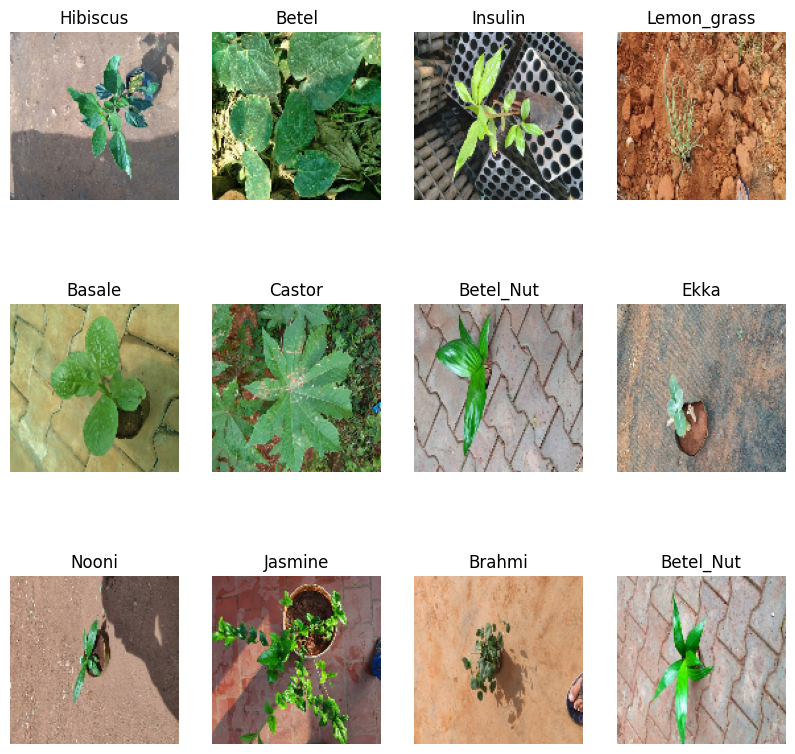

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

148.8

In [9]:
train_ds = dataset.take(172)
len(train_ds)

172

In [10]:
test_ds = dataset.skip(172)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

18.6

In [12]:
val_ds = test_ds.take(21)
len(val_ds)

14

In [13]:
test_ds = test_ds.skip(21)
len(test_ds)

0

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

148

In [17]:
len(val_ds)

18

In [18]:
len(test_ds)

20

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 40

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 128, 128, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 126, 126, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 63, 63, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 61, 61, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 30, 30, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 28, 28, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 14, 14, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    reduction='sum_over_batch_size'
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
148/148 [==============================] - 119s 674ms/step - loss: 3.6080 - accuracy: 0.0349 - val_loss: 3.4537 - val_accuracy: 0.0590
Epoch 2/10
148/148 [==============================] - 93s 624ms/step - loss: 3.2001 - accuracy: 0.1051 - val_loss: 2.9881 - val_accuracy: 0.1510
Epoch 3/10
148/148 [==============================] - 83s 561ms/step - loss: 2.8272 - accuracy: 0.1865 - val_loss: 2.6194 - val_accuracy: 0.2517
Epoch 4/10
148/148 [==============================] - 79s 529ms/step - loss: 2.5800 - accuracy: 0.2468 - val_loss: 2.5755 - val_accuracy: 0.2604
Epoch 5/10
148/148 [==============================] - 79s 533ms/step - loss: 2.3952 - accuracy: 0.2920 - val_loss: 2.3537 - val_accuracy: 0.3281
Epoch 6/10
148/148 [==============================] - 78s 526ms/step - loss: 2.2259 - accuracy: 0.3375 - val_loss: 2.4219 - val_accuracy: 0.2743
Epoch 7/10
148/148 [==============================] - 87s 586ms/step - loss: 2.1374 - accuracy: 0.3567 - val_loss: 2.3675 - val_a

In [27]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 13s 191ms/step - loss: 1.9341 - accuracy: 0.4297


In [28]:
scores

[1.9340928792953491, 0.4296875]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 148}

In [31]:
history.history

{'loss': [3.6080119609832764,
  3.200073003768921,
  2.827204704284668,
  2.5799620151519775,
  2.3951926231384277,
  2.2259037494659424,
  2.1374261379241943,
  1.9919593334197998,
  1.8983650207519531,
  1.7872322797775269],
 'accuracy': [0.034891098737716675,
  0.10509621351957321,
  0.18650877475738525,
  0.24677520990371704,
  0.29202792048454285,
  0.33749207854270935,
  0.3567350506782532,
  0.3931063711643219,
  0.41721293330192566,
  0.4588707983493805],
 'val_loss': [3.453660488128662,
  2.9880752563476562,
  2.6194305419921875,
  2.575547218322754,
  2.353731632232666,
  2.4218645095825195,
  2.3674633502960205,
  1.867422342300415,
  1.8793989419937134,
  1.8561962842941284],
 'val_accuracy': [0.0590277761220932,
  0.1510416716337204,
  0.2517361044883728,
  0.2604166567325592,
  0.328125,
  0.2743055522441864,
  0.2847222089767456,
  0.3993055522441864,
  0.4149305522441864,
  0.4548611044883728]}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Rose
predicted label: Curry_Leaf


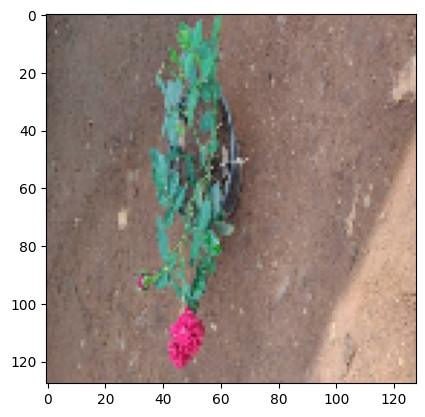

In [34]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


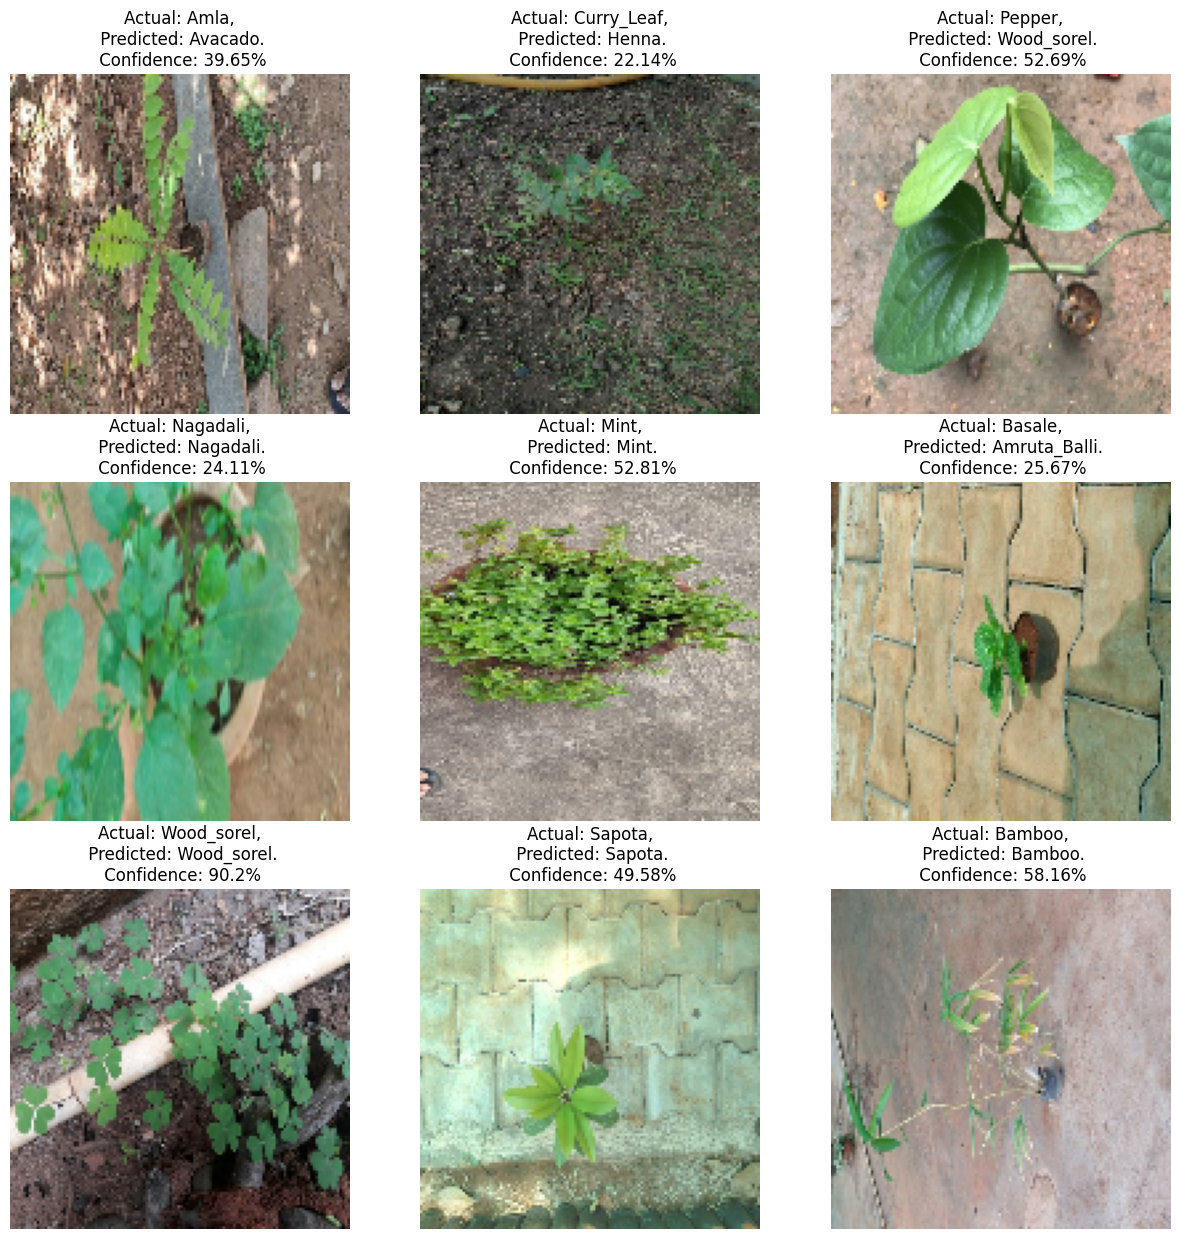

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [1]:


from fastapi import FastAPI, File, UploadFile
from fastapi.middleware.cors import CORSMiddleware
import uvicorn
import numpy as np
from io import BytesIO
from PIL import Image
import tensorflow as tf

app = FastAPI()

origins = [
    "http://localhost",
    "http://localhost:3000",
]
app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

MODEL = tf.keras.models.load_model("C://Users//Hp//Downloads//AyurVision//my_model.keras")

CLASS_NAMES = ['Aloevera', 'Amla', 'Amruta_Balli', 'Arali', 'Ashoka', 'Ashwagandha', 'Avacado', 'Bamboo', 'Basale', 'Betel', 'Betel_Nut',
              'Brahmi', 'Castor', 'Curry_Leaf', 'Doddapatre', 'Ekka', 'Ganike', 'Gauva', 'Geranium', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jasmine',
              'Lemon', 'Lemon_grass', 'Mango', 'Mint', 'Nagadali', 'Neem', 'Nithyapushpa', 'Nooni', 'Pappaya', 'Pepper', 'Pomegranate', 'Raktachandini', 'Rose',
              'Sapota', 'Tulasi', 'Wood_sorel']

@app.get("/ping")
async def ping():
    return "Hello, I am alive"

def read_file_as_image(data) -> np.ndarray:
    image = np.array(Image.open(BytesIO(data)))
    return image

@app.post("/predict")
async def predict(
    file: UploadFile = File(...)
):
    image = read_file_as_image(await file.read())
    img_batch = np.expand_dims(image, 0)
    
    predictions = MODEL.predict(img_batch)

    predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    return {
        'class': predicted_class,
        'confidence': float(confidence)
    }

if __name__ == "__main__":
    uvicorn.run(app, host='localhost', port=8000)

AttributeError: module 'numpy' has no attribute 'typeDict'

c:\Users\Hp\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\dtypes.py:511: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [38]:

model.save("my_model.h5")
